In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#function adding layer
def make_convlayer():
    
    #create sequential object
    model = Sequential()
    
    #add conv layer #1
    model.add(Conv2D(filters = 64,
                     padding = 'same',
                     kernel_size = (3,3),
                     activation = 'relu',
                     kernel_initializer = 'he_uniform',
                     input_shape = (32,32,3)))
    
    #add pooling
    model.add(MaxPooling2D(pool_size = 2))
    
    #add conv layer #2
    model.add(Conv2D(filters = 128,
                      padding = 'same',
                      kernel_size = (3,3),
                      activation = 'relu',
                      kernel_initializer = 'he_uniform'))
    
    #add pooling
    model.add(MaxPooling2D(pool_size = 2))
    
    #add conv layer #3
    model.add(Conv2D(filters = 256,
                     kernel_size = (3,3),
                     kernel_initializer = 'he_uniform',
                     padding = 'same',
                     activation = 'relu'))
    
    #add pooling
    model.add(MaxPooling2D(pool_size = 2))
    
    #flatten
    model.add(Flatten())
    
    #dropout()
    model.add(Dropout(0.5))
    
    #full connect
    model.add(Dense(512, 
                    activation = 'relu'))
    
    #output
    model.add(Dense(10,
                    activation = 'softmax'))
    
    #compile
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizers.Adam(lr = 0.001),
                  metrics = ['accuracy'])
    
    #return
    return model



In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import History, LearningRateScheduler

def step_decay(epoch):
    """
    decay in 1/5
    Parameters:
        epoch(int) training times
        Return: learning rate
    """
    lrate =0.001
    if epoch >=30: lrate = lrate / 5.0
    if epoch >=60: lrate = lrate/5.0
    if epoch >=90:lrate = lrate/5.0
    
    return lrate

def train_batchsize(model,data, batch_size, epochs, decay):
    """
    Parameters:
        model:(obj): Model object
        data(tuple): training set, testing set
        batch_size(int): batch size
        epochs(int): trianing epoch
        decay(float): learning rate
    """
    x_train, y_train, x_test, y_test = data
    
    #traiining data
    train_gen = ImageDataGenerator(rescale = 1.0/255.0, #normalization
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1,
                                   rotation_range = 10,
                                   zoom_range = 0.1,
                                   horizontal_flip = True
                                  ).flow(x_train, 
                                         y_train,
                                         batch_size = batch_size)
    
    #validation
    test_gen = ImageDataGenerator(rescale = 1.0/255.0
                                 ).flow(x_test, 
                                        y_test, 
                                        batch_size=128)
    
    hist = History()
    
    model.fit(train_gen,
              steps_per_epoch = x_train.shape[0] // batch_size,
              epochs = epochs,
              validation_data = test_gen,
              callbacks = [hist, decay])
    
    return hist.history

In [3]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def train(train_mode):
    """
    train_mode(int);
        0: normal batch_size=128,
           lr=0.001,0.0002,0.00004,0.000008
        1: increase batch = 128, 640, 3200, 16000
           lr = 0.001
    """
    
    #import data
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    data = (x_train, y_train, x_test, y_test)
    
    #create model
    model = make_convlayer()
    
    #initial hist object
    histories = []
    
    #set lrate decay schedule
    decay = LearningRateScheduler(step_decay)
    
    #batch size schedule
    same_lr = LearningRateScheduler(lambda epoch: 0.001)
    
    #lr decay
    if train_mode == 0:
        histories.append(train_batchsize(model,
                                        data,
                                        batch_size = 128,
                                        epochs = 120,
                                        decay = decay))
    #increase batch size
    if train_mode == 1:
        histories.append(train_batchsize(model,
                                         data,
                                         batch_size = 128,
                                         epochs = 30,
                                         decay = same_lr))
        histories.append(train_batchsize(model,
                                         data,
                                         batch_size = 640,
                                         epochs = 30,
                                         decay = same_lr))
        histories.append(train_batchsize(model,
                                         data,
                                         batch_size = 3200,
                                         epochs = 30,
                                         decay = same_lr))
        histories.append(train_batchsize(model,
                                         data,
                                         batch_size = 16000,
                                         epochs = 30,
                                         decay = same_lr))
            
    #integrate history
    joined_history = histories[0]
    for i in range(1, len(histories)):
        for key, value in histories[i].items():
            joined_history[key] = joined_history[key] = value
            
    return joined_history

In [4]:
%%time
history = train(0)

170508288/170498071 [==============================] - 3s 0us/step


2022-06-14 04:38:17.473357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 04:38:17.648050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 04:38:17.648802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 04:38:17.649960: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/120


2022-06-14 04:38:22.226539: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


390/390 [==============================] - 33s 66ms/step - loss: 1.6603 - accuracy: 0.4065 - val_loss: 1.2600 - val_accuracy: 0.5465
Epoch 2/120
390/390 [==============================] - 25s 65ms/step - loss: 1.2969 - accuracy: 0.5361 - val_loss: 1.1481 - val_accuracy: 0.5908
Epoch 3/120
390/390 [==============================] - 25s 63ms/step - loss: 1.1427 - accuracy: 0.5919 - val_loss: 1.1087 - val_accuracy: 0.6068
Epoch 4/120
390/390 [==============================] - 26s 66ms/step - loss: 1.0475 - accuracy: 0.6266 - val_loss: 0.9239 - val_accuracy: 0.6799
Epoch 5/120
390/390 [==============================] - 25s 65ms/step - loss: 0.9653 - accuracy: 0.6614 - val_loss: 0.8603 - val_accuracy: 0.6975
Epoch 6/120
390/390 [==============================] - 25s 65ms/step - loss: 0.9085 - accuracy: 0.6791 - val_loss: 0.8059 - val_accuracy: 0.7211
Epoch 7/120
390/390 [==============================] - 24s 63ms/step - loss: 0.8671 - accuracy: 0.6950 - val_loss: 0.7822 - val_accuracy: 0.72

In [5]:
%%time
history_batch = train(1)

Epoch 1/30
390/390 [==============================] - 25s 62ms/step - loss: 1.6629 - accuracy: 0.4064 - val_loss: 1.2753 - val_accuracy: 0.5548
Epoch 2/30
390/390 [==============================] - 27s 68ms/step - loss: 1.2770 - accuracy: 0.5460 - val_loss: 1.0444 - val_accuracy: 0.6328
Epoch 3/30
390/390 [==============================] - 27s 70ms/step - loss: 1.1299 - accuracy: 0.5977 - val_loss: 0.9339 - val_accuracy: 0.6705
Epoch 4/30
390/390 [==============================] - 27s 69ms/step - loss: 1.0205 - accuracy: 0.6387 - val_loss: 1.0158 - val_accuracy: 0.6472
Epoch 5/30
390/390 [==============================] - 27s 69ms/step - loss: 0.9527 - accuracy: 0.6629 - val_loss: 0.8430 - val_accuracy: 0.6994
Epoch 6/30
390/390 [==============================] - 27s 68ms/step - loss: 0.8972 - accuracy: 0.6840 - val_loss: 0.8396 - val_accuracy: 0.7084
Epoch 7/30
390/390 [==============================] - 27s 69ms/step - loss: 0.8555 - accuracy: 0.6967 - val_loss: 0.6898 - val_accuracy:

Text(0, 0.5, 'Acc')

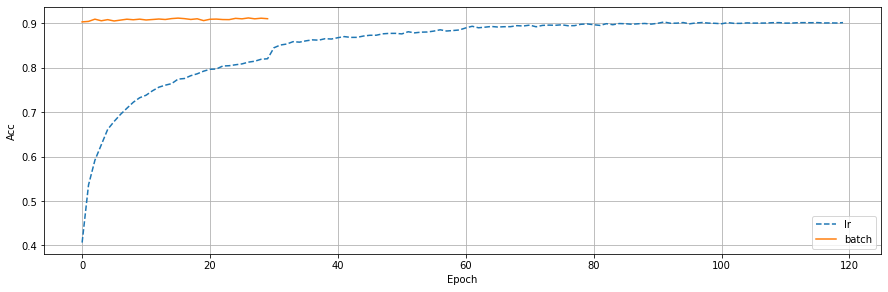

In [6]:
#training
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (15, 10)) #ploting size
plt.subplot(2,1,1) #plot on (2x1) gird

#plot lrate decay accuracy trending
plt.plot(history['accuracy'], label = 'lr', linestyle = '--')

#plot batch size accuracy trending
plt.plot(history_batch['accuracy'], label = 'batch')

plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Acc")


Text(0, 0.5, 'Acc')

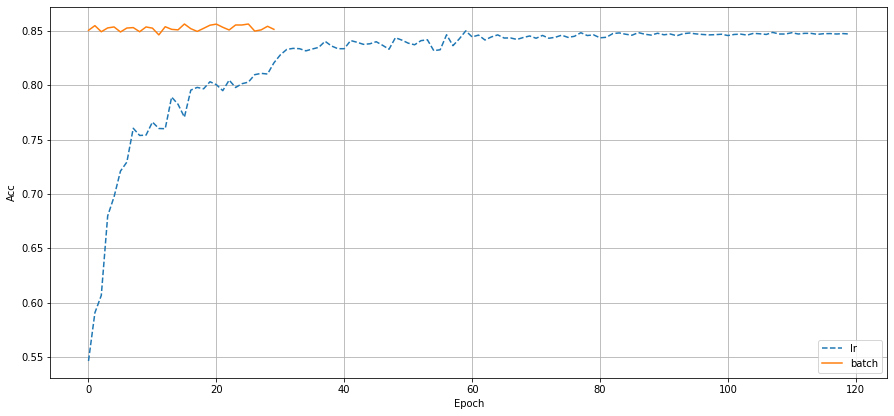

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (15,15))
plt.subplot(2,1,1)

#plot lr rate decay accuracy trending
plt.plot(history['val_accuracy'], label = 'lr', linestyle = '--')
#plot batch_size accuracy trending 
plt.plot(history_batch['val_accuracy'], label = 'batch')

plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel('Acc')